## 一、数据预处理

In [1]:
import os
import numpy as np
import pandas as pd
from collections import OrderedDict
import re, string

import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchkeras
from torchkeras import Model

In [2]:
# MAX_WORDS = 10000 # 仅考虑最高频的10000个词
MAX_LEN = 200 # 每个样本保留200个词的长度
BATCH_SIZE = 20

train_data_path = './data/imdb/train.tsv'
test_data_path = './data/imdb/test.tsv'

train_token_path = './data/imdb/train_token.tsv'
test_token_path = './data/imdb/test_token.tsv'

train_samples_path = './data/imdb/train_samples/'
test_samples_path = './data/imdb/test_samples/'

In [3]:
# 构建词典
word_count_dict = {}

# 清洗文本
def clean_text(text):
    lowercase = text.lower().replace('\n', ' ') # '\n' 替换为 ' '
    stripped_html = re.sub('<br />', ' ', lowercase) # '<br />' 替换为 ' '
    cleaned_punctuation = re.sub('[%s]'%re.escape(string.punctuation), '', stripped_html) # 去掉所有标点
    return cleaned_punctuation

with open (train_data_path, 'r', encoding='UTF-8') as f:
    for line in f:
        label, text = line.split('\t')
        cleaned_text = clean_text(text)
        for word in cleaned_text.split(' '):
            word_count_dict[word] = word_count_dict.get(word, 0)+1 #


MAX_WORDS = len(word_count_dict)
df_word_dict = pd.DataFrame(pd.Series(word_count_dict, name = "count")) # 字典转为dataframe, 只有一列列名count
df_word_dict = df_word_dict.sort_values(by = "count", ascending =False) # 降序排列

df_word_dict = df_word_dict[0:MAX_WORDS-2] # 总共取前(MAX_WORDS-2)个词 
df_word_dict["word_id"] = range(2,MAX_WORDS) # 编号0和1分别留给未知词<unkown>和填充<padding>

word_id_dict = df_word_dict["word_id"].to_dict()
word_id_dict['<unknown>'] = 0
word_id_dict['<padding>'] = 1


id_word_dict = {}
id_word_dict = {v: k for k,v in word_id_dict.items()}

In [4]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

glove_path = '/Users/anthonywu/K/stu/Material/glove.6B/glove.6B.100d.txt'

# 预训练好的词向量
pre_file = datapath(glove_path)

# glove需要转化为word2vec格式后文件的位置
tmp_file = get_tmpfile("glove2w2v.txt")

# 转化
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(pre_file, tmp_file)

(400000, 100)

In [5]:
# 使用gensim载入转化后的词向量
wvmodel = KeyedVectors.load_word2vec_format(tmp_file, binary=False, encoding='UTF-8')

In [6]:
# 使用加载好的预训练词向量

vocab_size = len(word_id_dict) # 
embed_size = 100
weight = torch.zeros(vocab_size, embed_size)

for i in range(len(wvmodel.index2word)):
    try:
        index = word_id_dict[wvmodel.index2word[i]]
    except:
        continue
    weight[index, :] = torch.from_numpy(wvmodel.get_vector(id_word_dict[word_id_dict[wvmodel.index2word[i]]]))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  if sys.path[0] == '':


In [7]:
# 文件已处理为token_id, 对每个文件需要根据词的id找到词，然后找到词对应的词向量

class imdbDataset(Dataset):
    # 如果需要自定义Dataset，就需要实现__getitem__（）和 __len__（）方法。
    
    def __init__(self, samples_dir):
        self.samples_dir = samples_dir
        self.samples_paths = os.listdir(samples_dir) # samples_dir下的所有文件，返回文件名list
    
    def __len__(self):
        return len(self.samples_paths) # 返回samples_dir下所有文件个数

    def __getitem__(self, index):
        path = self.samples_dir + '/' + self.samples_paths[index]
        with open(path, 'r', encoding="UTF-8") as f:
            line = f.readline()
            label, tokens = line.split("\t")
            label = torch.tensor([float(label)], dtype = torch.float)
            feature = torch.tensor([int(x) for x in tokens.split(" ")], dtype = torch.long)
            return  (feature, label)

In [8]:
ds_train = imdbDataset(train_samples_path)
ds_test = imdbDataset(test_samples_path)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

for features, labels in dl_train:
    print(features.shape)
    print(labels.shape)
    break

torch.Size([20, 200])
torch.Size([20, 1])


In [9]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper params
H_SIZE = 64
N_LAYERS = 1
EMBEDDING_DIM = 100

class BiLSTM(Model):
    def __init__(self, hidden_size=H_SIZE, num_layers=N_LAYERS):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.embedding.weight.requires_grad = True # requires_grad指定是否在训练过程中对词向量的权重进行微调
        self.lstm = nn.LSTM(EMBEDDING_DIM, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x, (h0, c0)) # output shape: (batch_size=20, MAX_LEN=200, hidden_size*2=128)
        x_in = lstm_out[:, -1, :] # shape: (20, 128)
        
        y = nn.Sigmoid()(self.fc(x_in))
        return y

model = BiLSTM()
print(model)
model.summary(input_shape = (200, ), input_dtype = torch.LongTensor)

BiLSTM(
  (embedding): Embedding(99925, 100)
  (lstm): LSTM(100, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1             [-1, 200, 100]       9,992,500
              LSTM-2             [-1, 200, 128]          84,992
            Linear-3                    [-1, 1]             129
Total params: 10,077,621
Trainable params: 10,077,621
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000763
Forward/backward pass size (MB): 0.347908
Params size (MB): 38.443073
Estimated Total Size (MB): 38.791744
----------------------------------------------------------------


In [10]:
def accuracy(y_pred, y_true):
    y_pred = torch.where(y_pred > 0.5, 
                         torch.ones_like(y_pred, dtype=torch.float32), 
                         torch.zeros_like(y_pred, dtype=torch.float32))
    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc

model.compile(loss_func=nn.BCELoss(), 
              optimizer=torch.optim.Adagrad(model.parameters(), lr = 0.02), 
              metrics_dict={"accuracy":accuracy})

In [11]:
epochs = 10
dfhistory = model.fit(epochs, dl_train, dl_val=dl_test, log_step_freq=200) 

Start Training ...

================================================================================2021-01-22 16:10:16
{'step': 200, 'loss': 0.639, 'accuracy': 0.625}
{'step': 400, 'loss': 0.583, 'accuracy': 0.688}
{'step': 600, 'loss': 0.524, 'accuracy': 0.734}
{'step': 800, 'loss': 0.478, 'accuracy': 0.765}
{'step': 1000, 'loss': 0.448, 'accuracy': 0.785}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.448 |  0.785   |  0.307   |    0.869     |
+-------+-------+----------+----------+--------------+

================================================================================2021-01-22 16:12:55
{'step': 200, 'loss': 0.268, 'accuracy': 0.895}
{'step': 400, 'loss': 0.259, 'accuracy': 0.899}
{'step': 600, 'loss': 0.253, 'accuracy': 0.902}
{'step': 800, 'loss': 0.252, 'accuracy': 0.901}
{'step': 1000, 'loss': 0.248, 'accuracy': 0.904}

 +-------+-------+-

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


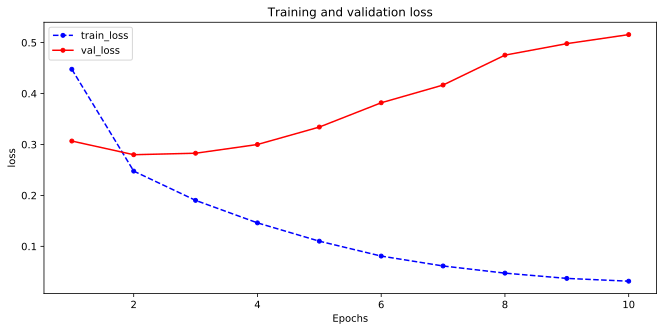

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.figure(figsize=(11, 5))
    plt.plot(epochs, train_metrics, 'bo--', markersize=4)
    plt.plot(epochs, val_metrics, 'ro-', markersize=4)
    plt.title('Training and validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_'+metric, 'val_'+metric])
    #plt.savefig(metric+'_BiLSTM.png', dpi=600)
    plt.show()

plot_metric(dfhistory, "loss")

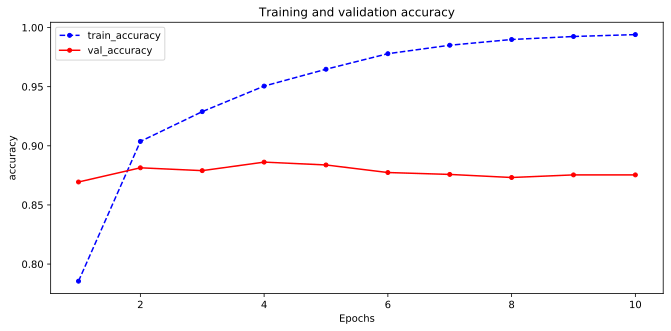

In [13]:
plot_metric(dfhistory, "accuracy")